# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Loading

In [2]:
data = pd.read_csv(f'../data/train.csv').values
X_full, y_full = data[:, :-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=0)

# LDA & Naive Bayes 

## LDA Gridsearch

In [3]:
scalers = [None, StandardScaler(), MinMaxScaler()]
classifiers = [GaussianNB(), MultinomialNB()]

def get_lda_param_grid(X_train, y_train):
    n_classes = len(np.unique(y_train))
    max_components = min(X_train.shape[1], n_classes - 1)
    n_comp_list = list(range(1, max_components + 1))
    param_grid = []

    for n_components in n_comp_list:
        for solver in ['svd', 'eigen']:
            for store_cov in [True, False]:
                param_grid.append({
                    'lda__n_components': [n_components],
                    'lda__solver': [solver],
                    'lda__store_covariance': [store_cov]
                })
    return param_grid

def search_lda_pipeline(X_train, y_train, X_test, y_test, scoring, n_jobs, cv):
    results = []
    param_grid = get_lda_param_grid(X_train, y_train)
    for scaler in scalers:
        for clf in classifiers:
            steps = []
            if scaler is not None:
                steps.append(('scl', scaler))
            steps.append(('lda', LDA()))
            if isinstance(clf, MultinomialNB):
                steps.append(('minmax', MinMaxScaler()))
            steps.append(('clf', clf))

            pipeline = Pipeline(steps)
            scaler_name = scaler.__class__.__name__ if scaler is not None else 'None'

            try:
                grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, error_score='raise')
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                y_pred = best_model.predict(X_test)

                results.append({
                    'scaler': scaler_name,
                    'classifier': clf.__class__.__name__,
                    'best_params': grid.best_params_,
                    'best_cv_mean': grid.best_score_,
                    'best_cv_std': grid.cv_results_['std_test_score'][grid.best_index_],
                    'test_accuracy': accuracy_score(y_test, y_pred),
                })

            except Exception as e:
                print(f'Skipped scaler={scaler_name}, clf={clf.__class__.__name__}: {e}')
                continue
    return pd.DataFrame(results)

In [4]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
lda_results = search_lda_pipeline(X_train, y_train, X_test, y_test, scoring='accuracy', n_jobs=16, cv=cv)

In [5]:
lda_results

,scaler,classifier,best_params,best_cv_mean,best_cv_std,test_accuracy
0,None,GaussianNB,"{'lda__n_components': 1, 'lda__solver': 'svd',...",0.945375,0.012736,0.9625
1,None,MultinomialNB,"{'lda__n_components': 3, 'lda__solver': 'svd',...",0.671938,0.027375,0.6975
2,StandardScaler,GaussianNB,"{'lda__n_components': 1, 'lda__solver': 'svd',...",0.945375,0.012736,0.9625
3,StandardScaler,MultinomialNB,"{'lda__n_components': 3, 'lda__solver': 'svd',...",0.671938,0.027375,0.6975
4,MinMaxScaler,GaussianNB,"{'lda__n_components': 1, 'lda__solver': 'svd',...",0.945375,0.012736,0.9625
5,MinMaxScaler,MultinomialNB,"{'lda__n_components': 3, 'lda__solver': 'svd',...",0.671938,0.027375,0.6975


## Plot LDA 2D Projection

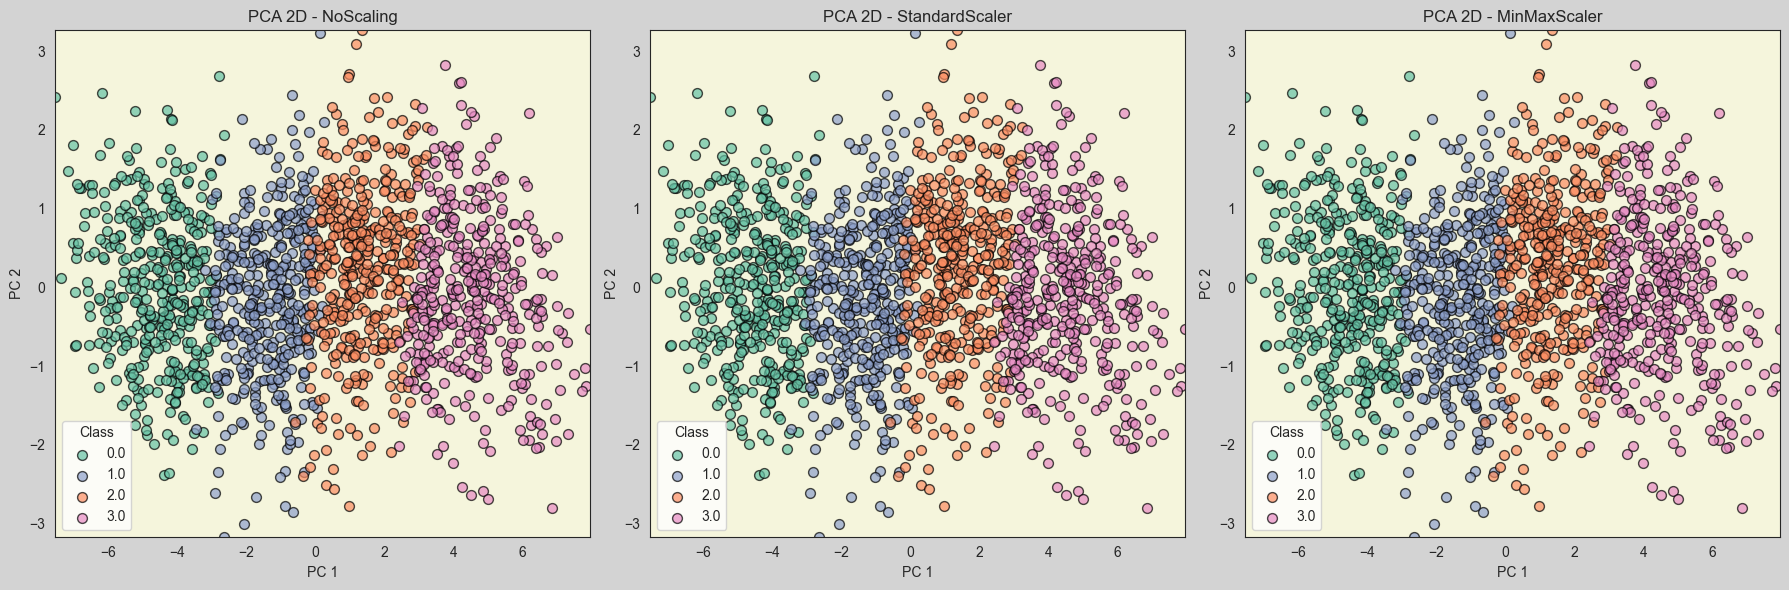

In [6]:
lda_params = {
    'n_components': 2,
    'solver': 'svd',
    'store_covariance': True
}

scalers = {
    'NoScaling': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

colors = ['#66c2a5', '#8da0cb', '#fc8d62', '#e78ac3']

sns.set_style('white')
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False, sharey=False)
fig.patch.set_facecolor('lightgray')

for ax, (scaler_name, scaler) in zip(axes, scalers.items()):

    X_processed = scaler.fit_transform(X_train) if scaler else X_train
    lda = LDA(**lda_params)
    X_projected = lda.fit_transform(X_processed, y_train)

    X_min, X_max = X_projected[:, 0].min(), X_projected[:, 0].max()
    y_min, y_max = X_projected[:, 1].min(), X_projected[:, 1].max()

    classes = np.unique(y_train)
    for idx, cls in enumerate(classes):
        mask = (y_train == cls)
        ax.scatter(X_projected[mask, 0], X_projected[mask, 1], color=colors[idx], label=str(cls), alpha=0.7, edgecolor='k', s=50)

    ax.set_title(f'PCA 2D - {scaler_name}')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_facecolor('#f5f5dc')
    ax.grid(False)
    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(title='Class')

plt.tight_layout()
plt.show()    



# Final Evaluation - Confusion Matrix

Test accuracy: 0.9600


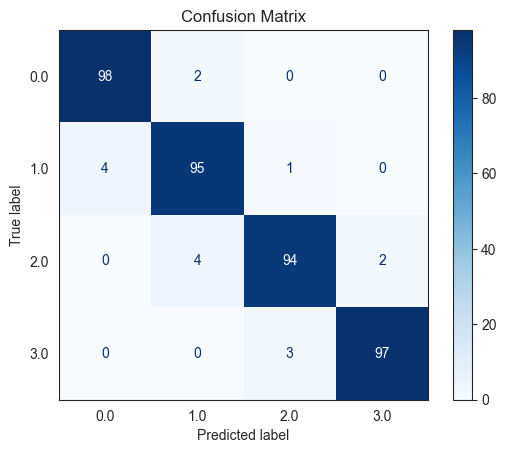

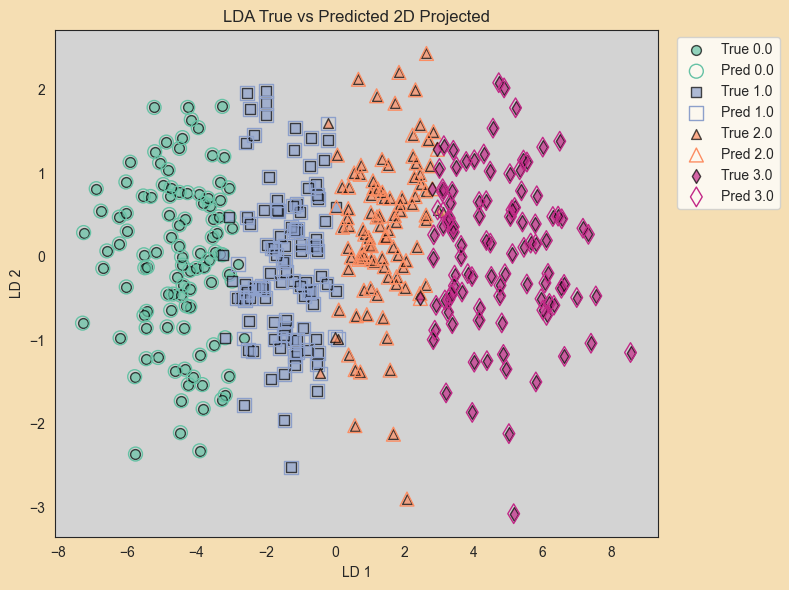

In [7]:
lda_params = {'n_components': 3,
              'solver': 'svd',
              'store_covariance': True}
scaler = None
clf = GaussianNB()

steps = []
if scaler is not None:
    steps.append(('scaler', scaler))
steps.append(('lda', LDA(**lda_params)))
steps.append(('clf', clf))
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(f'Test accuracy: {accuracy_score(y_test, y_pred):.4f}')


disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(y_full), cmap='Blues')
disp.ax_.set_facecolor('lightgray')
disp.ax_.set_title('Confusion Matrix')
plt.show()

X_projected = pipe.named_steps['lda'].transform(pipe.named_steps['scaler'].transform(X_test)) if scaler else pipe.named_steps['lda'].transform(X_test)
classes = np.unique(y_test)
colors = ['#66c2a5', '#8da0cb', '#fc8d62', "#c22887"]
markers = ['o', 's', '^', 'd']

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#F5DEB3')
ax.set_facecolor('lightgray')

for i, cls in enumerate(classes):
    mask_true = (y_test == cls)
    ax.scatter(X_projected[mask_true, 0], X_projected[mask_true, 1], color=colors[i], marker=markers[i], label='True '+str(cls), alpha=0.7, edgecolor='k', s=50)

    mask_pred = (y_pred == cls)
    ax.scatter(X_projected[mask_pred, 0], X_projected[mask_pred, 1], facecolors='none', marker=markers[i], label='Pred '+str(cls), edgecolors=colors[i], s=100)

ax.set_title('LDA True vs Predicted 2D Projected')
ax.set_xlabel('LD 1')
ax.set_ylabel('LD 2')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(False)
plt.tight_layout()
plt.show()